Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Rescaling,RandomFlip, RandomRotation,RandomContrast, RandomZoom,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!unzip -q /content/gdrive/MyDrive/CNN_assignment.zip -d /content/CNN_assignment/

In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Writing train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Writing validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print (len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

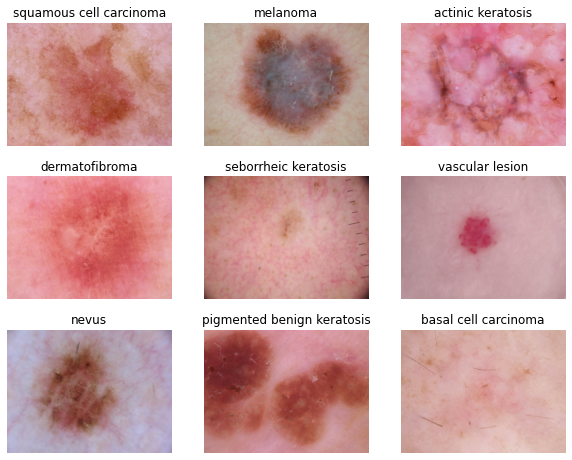

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
fig=plt.figure(figsize=(10,8))
counter=1
for f in data_dir_train.iterdir():
  im=Image.open(f.iterdir().__next__())
  plt.subplot(3,3,counter)
  plt.imshow(im)
  plt.title(str(f).split('/')[-1])
  counter+=1
  plt.axis("off")



In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

num_classes = 9

model = Sequential([
  Rescaling(1./255,input_shape=(180,180,3)),
  Conv2D(32, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
  
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy'  ,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 85ms/step - loss: 2.4389 - accuracy: 0.2846 - val_loss: 1.8263 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6569 - accuracy: 0.3956 - val_loss: 1.4813 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4083 - accuracy: 0.5162 - val_loss: 1.5153 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2676 - accuracy: 0.5508 - val_loss: 1.5480 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2216 - accuracy: 0.5653 - val_loss: 1.5151 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.0474 - accuracy: 0.6289 - val_loss: 1.4491 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 0.9913 - accuracy: 0.6624 - val_loss: 1.4504 - val_accuracy: 0.5414
Epoch 8/20
5

### Visualizing training results

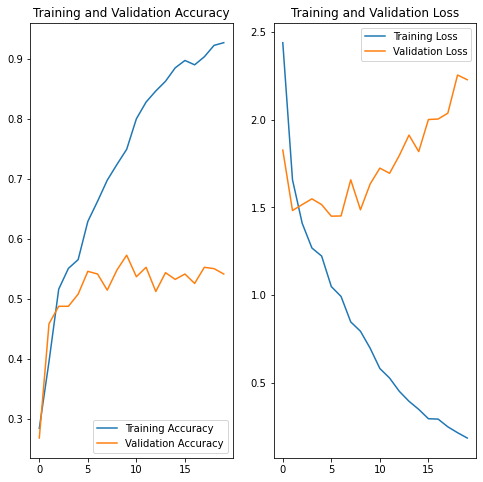

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings: 
1. Training accuracy is continuously increasing
2. Validation accuracy increases till few epochs and then remains almost constant <br>
This is a clear sign of overfitting, wherein validation accuracy is quite low as compared to training accuracy at the end of training.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = Sequential([
  #RandomFlip("horizontal_and_vertical",input_shape=(180,180,3)),
  RandomRotation(0.2,input_shape=(180,180,3)),
  RandomContrast(0.4),
  RandomZoom(.5, .2)
])

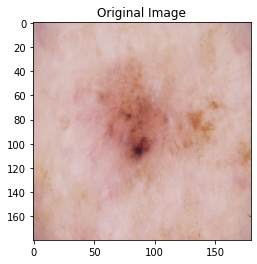

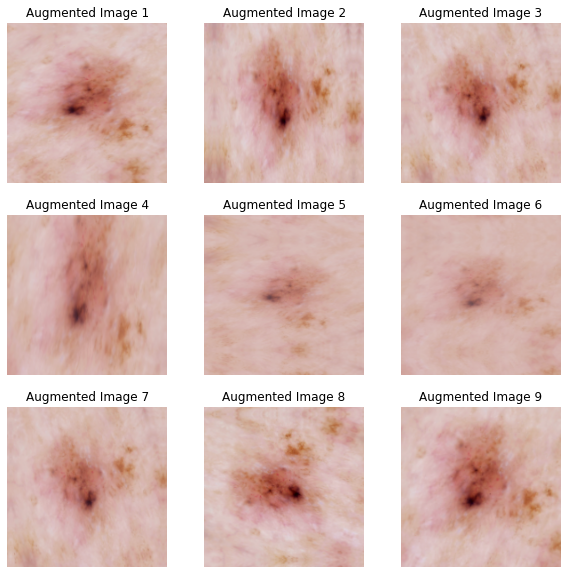

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

for batch,labels in train_ds.take(1):
  im=batch[0]
  #print(im)
  im=tf.reshape(im,(1,img_width,img_height,3))
  #print(im)
  plt.title ('Original Image')
  plt.imshow(im[0].numpy().astype("uint8"))
  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.title (f"Augmented Image {i+1}")
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:

num_classes = 9

model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
  
])


### Compiling the model

In [21]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

### Training the model

In [23]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 295ms/step - loss: 2.0593 - accuracy: 0.2885 - val_loss: 1.7487 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 17s 299ms/step - loss: 1.7480 - accuracy: 0.3672 - val_loss: 1.5689 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 17s 306ms/step - loss: 1.6384 - accuracy: 0.4174 - val_loss: 1.5537 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 16s 290ms/step - loss: 1.6052 - accuracy: 0.4291 - val_loss: 1.4570 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 16s 289ms/step - loss: 1.5177 - accuracy: 0.4743 - val_loss: 1.4290 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 16s 291ms/step - loss: 1.4886 - accuracy: 0.4771 - val_loss: 1.4056 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 16s 290ms/step - loss: 1.5380 - accuracy: 0.4587 - val_loss: 1.3828 - val_accuracy: 0.5213

### Visualizing the results

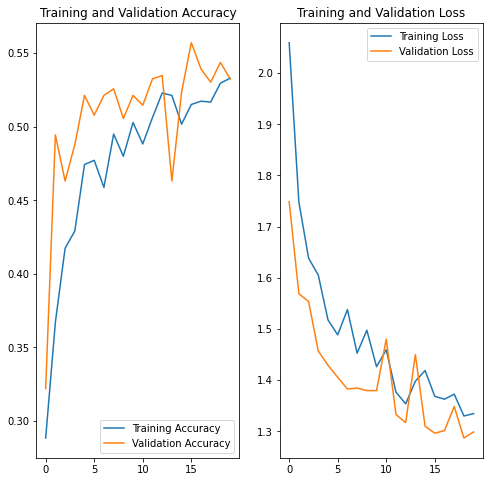

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
1. Training accuracy has significantly reduced
2. Both training and validation accuracies are quite low
3. Probably, augmentation has led to underfitting

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
      seborrheic keratosis 

#### - Which classes dominate the data in terms proportionate number of samples?
      pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAD031AD220>: 100%|██████████| 500/500 [00:24<00:00, 20.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD030D0AC0>: 100%|██████████| 500/500 [00:25<00:00, 19.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAD03003B80>: 100%|██████████| 500/500 [00:21<00:00, 23.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAD05CDD400>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7FAD101AB640>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAD021067C0>: 100%|██████████| 500/500 [00:19<00:00, 25.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAD07F3CE80>: 100%|██████████| 500/500 [00:47<00:00, 10.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD0212E040>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAD07F02940>: 100%|██████████| 500/500 [00:20<00:00, 24.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))  ##Count of images added
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027753.jpg_77f22e25-de32-4e43-b6dc-8fe056484c78.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024925.jpg_da2cd467-7a1e-4c80-9a95-c7381e9e47c7.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031198.jpg_5ed28241-5f4c-4580-9458-d02bf238e62f.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_368b55b8-d6bc-48ce-aa07-5403232687b6.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squ

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [33]:
new_df['Label'].value_counts()

melanoma                      938
squamous cell carcinoma       681
actinic keratosis             614
dermatofibroma                595
pigmented benign keratosis    462
basal cell carcinoma          376
nevus                         357
seborrheic keratosis          316
vascular lesion               139
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
data_dir_train

PosixPath('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [39]:
# AutoTune & cache for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
     

#### **Todo:** Create your model (make sure to include normalization)

In [49]:
num_classes = 9

model = Sequential([
  Rescaling(1./255,input_shape=(img_height,img_width,3)),
  Conv2D(16, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.1),
  Conv2D(32, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.1),
  Conv2D(64, 3, activation='relu', padding='same'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.1),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
  
])

In [50]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)  ,
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [52]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 6s 28ms/step - loss: 2.1777 - accuracy: 0.1753 - val_loss: 2.0543 - val_accuracy: 0.2071
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.7894 - accuracy: 0.3296 - val_loss: 1.5666 - val_accuracy: 0.4529
Epoch 3/30
169/169 [==============================] - 4s 27ms/step - loss: 1.5193 - accuracy: 0.4299 - val_loss: 1.4828 - val_accuracy: 0.5004
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 1.4244 - accuracy: 0.4664 - val_loss: 1.2755 - val_accuracy: 0.5071
Epoch 5/30
169/169 [==============================] - 5s 28ms/step - loss: 1.3063 - accuracy: 0.5041 - val_loss: 1.1592 - val_accuracy: 0.5620
Epoch 6/30
169/169 [==============================] - 5s 27ms/step - loss: 1.2702 - accuracy: 0.5206 - val_loss: 1.2242 - val_accuracy: 0.5642
Epoch 7/30
169/169 [==============================] - 5s 27ms/step - loss: 1.1574 - accuracy: 0.5568 - val_loss: 1.0012 - val_accuracy: 0.6244

#### **Todo:**  Visualize the model results

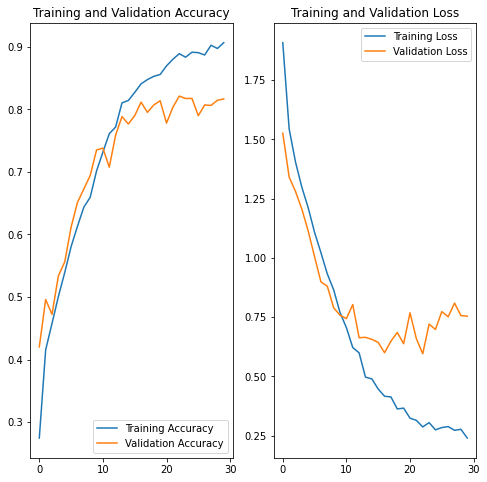

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
1. Class Rebalance helped to get rid of underfitting caused by augmentation in model 2
2. Model is generalizing well with Training accuracy = 0.86 and Validation accuracy  = 0.84

